In [ ]:
%pylab inline

import sys
if r'D:\\!Data' not in sys.path:
   sys.path.append(r'D:\\!Data')
# sys.path.append(r'/Users/artemgolovizin/GitHub')
from scipy.optimize import curve_fit
import inspect
import os
import pickle
import imp

from IPython import parallel

import thulium_python_lib.image_processing_new as impr
rc1 = parallel.Client()
lview = rc1.load_balanced_view()
dview = rc1.direct_view()
with dview.sync_imports():
    import sys, os    
%px if r'D:\\!Data' not in sys.path: sys.path.append(r'D:\\!Data')
#%px if r'/Users/artemgolovizin/GitHub' not in sys.path: sys.path.append(r'/Users/artemgolovizin/GitHub')
%px import thulium_python_lib.image_processing_new as impr
%px import imp
%px from IPython.parallel import bind_kernel; bind_kernel()

In [2]:
# to reload library on remote and local engine
#%px imp.reload(impr)
#imp.reload(impr)

###And now:
###Constract loader and averager 
For available parameters see help('instance')

In [2]:
loader  = impr.Load_Image(dview)
averager = impr.Avr_Image(dview)

###Setting directory to work with 

####Set date of measurement directory and create folder Figures 

In [4]:
cd 'D:\!Data\2015_08_20'

D:\!Data\2015_08_20


In [5]:
print('Current directory', os.getcwd());
# Create folder 'Figures' for saving individual plot
if not os.path.exists('Figures'):
    os.makedirs('Figures')
    print('Folder Figures has been created')

Current directory D:\!Data\2015_08_20
Folder Figures has been created


####Set measurement folder 

In [6]:
folder = '01 Temperature/'

working_directory = os.path.join(os.getcwd(),folder)
print('Working directory', working_directory)

Working directory D:\!Data\2015_08_20\01 Temperature/


###Loading images  

In [7]:
# downloading images
all_data = loader(working_directory,lview)

  35/35 tasks finished after    2 s
done
Total number of images:  35


In [8]:
# rearranging to dictionary
dataD = impr.rearrange_data(all_data)

Rearranging to dictionary is complited


In [9]:
# sifting(filtering) data - removing empty images  !!! DOES NOTE WORKS NOW
#impr.sift(dataD)

In [10]:
# for plotting sifted image
#imshow(imread('1 от частоты амплитудной модуляции аома верди (5) 3.9W/26ms/2_1.png'))
#colorbar()

In [11]:
# averaging data
avr_dataD = averager(dataD,lview)

   7/7 tasks finished after    0 s
done



###Helper functions

In [12]:
def exp_decay(t, N0, tau, background):
    return N0 * exp(- t / tau) + background
def exp_decay_no_bg(t, N0, tau):
    return N0 * exp(- t / tau)
def cloud_expansion(t, r0,T, t0):
    k_b = 1.38e-23
    m = 169 * 1.66e-27
    return sqrt( r0**2 + 2 * k_b * T * (t + t0)**2 / m)

# function to convert arbitrary units to atoms number
convert_N_atoms = impr.N_atoms(width=0.5, delta = 5)

### After above, we can analize our data 

####Construct  data

In [13]:
shot_typeN = 1
# first set of data  - Temperature X
d1 = impr.get_avr_data_for_plot(avr_dataD, shot_typeN, impr.real_size, 'fit1D_x',2)
d1['fmt']='ro'
d1['label']='fit1D_x'
#impr.drop_by_number(d1,5)
#impr.drop_by_x(d1,130,160)

# second set of data  - Temperature Y
d2 = impr.get_avr_data_for_plot(avr_dataD, shot_typeN, impr.real_size, 'fit1D_y',2)
d2['fmt']='bo'
d2['label'] = 'fit1D_y'
#impr.drop_by_number(d2,5)

# third set of data - number of atoms 
d4 = impr.get_avr_data_for_plot(avr_dataD, shot_typeN, convert_N_atoms, 'fit1D_x',0)
d4['fmt']='bo'
d4['label']='fit1D_x'

####Fitting 

In [14]:
# fit_func - which function to use to fit data
fit_func = cloud_expansion
popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0],20,0))
print('Fit parameters',*list(zip(inspect.getargspec(fit_func)[0][1:], popt_T)))
popt_T2, pcov_T2 = curve_fit(fit_func, d2['x'], d2['y'], p0=(d2['y'][0], 20,0))
print('Fit parameters',*list(zip(inspect.getargspec(fit_func)[0][1:], popt_T2)))

Fit parameters ('r0', 148.09628683115994) ('T', 13.867152152403756) ('t0', 0.81657844363675214)
Fit parameters ('r0', 103.98758160936113) ('T', 15.773488676690423) ('t0', 1.7025759301861734)


###Plot data 

####Main plot (1) 

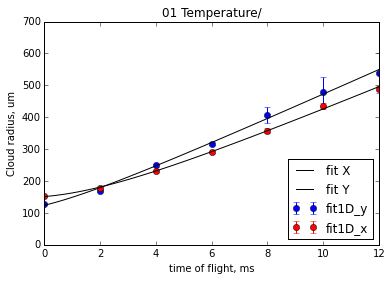

In [15]:
fig1, ax1 = subplots()
ax1.errorbar(**d2)
ax1.errorbar(**d1)

ax1.plot(linspace(min(d1['x']),max(d1['x']),100), fit_func(linspace(min(d1['x']),max(d1['x']),100),*popt_T),'k', label='fit X')
ax1.plot(linspace(min(d2['x']),max(d2['x']),100), fit_func(linspace(min(d2['x']),max(d2['x']),100),*popt_T2),'k', label='fit Y')

ax1.set_xlabel('time of flight, ms')
ax1.set_ylabel('Cloud radius, um')
ax1.set_title(folder)
ax1.set_ylim(bottom=0)
ax1.legend(loc=4)


####Main plot (2)  - number of atoms 

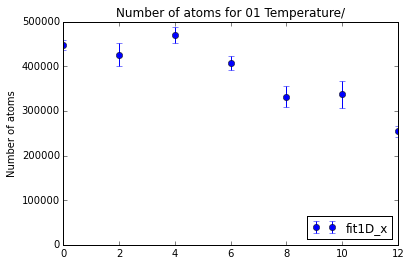

In [16]:
fig3, ax3 = subplots()
ax3.errorbar(**d4)
ax1.set_xlabel('time of flight, ms')
ax3.set_ylabel('Number of atoms')
ax3.set_title('Number of atoms for ' + folder)
ax3.set_ylim(bottom=0)
ax3.legend(loc=4)

###Plot of each image - to check if everything is ok 

(0, 50.0)

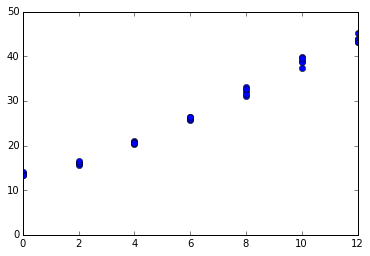

In [17]:
# for each picture
d3 = dict()
d3['x'],d3['y'] = impr.constract_data(dataD, shot_typeN, 'fit1D_x',2)

fig2, ax2 = subplots()
ax2.errorbar(fmt='o',**d3)
ax2.set_ylim(bottom=0)

####Save plots to folder 'Figures' (if in outter directory) and data to file 'all_N_atoms_data.txt' 

In [18]:
if folder != '':
    fig1.savefig(os.path.join('Figures',folder.rstrip(r'\/ ')+'--tempearture.png'))
    # if one need to save atom nubmer:
    #fig3.savefig(os.path.join('Figures',folder.rstrip(r'\/ ')+'--N_atoms.png'))
    try:
        with open('all_N_atoms_data.txt', 'rb') as handle:
            res_dict = pickle.loads(handle.read())
    except FileNotFoundError:
        res_dict = {}
    except EOFError:
        res_dict = {}
    res_dict[folder.rstrip(r'\/ ')]=(d1['x'], d1['y'])
    with open('all_N_atoms_data.txt', 'wb') as handle:
        pickle.dump(res_dict, handle)
    print('Figure and data saved!!!')

Figure and data saved!!!


####Normalize average data

In [ ]:
#norm_avr_dataD = normalise_avr_image(avr_dataD, 1, 2, 'x_data_fit',0)

####Normalize each image

In [ ]:
#norm_dataD = normalise_individual_image(dataD, 1, 2, 'x_data_fit',0)


####And do smth with this data

####Looking at second shot_typeN

#x_data,y_data = constract_data(avr_dataD, 2, 'total')
#plot(append(x_data, 0), append(y_data,0), 'o')